# Exploration of the first batch of validation results

# 0. Import dependencies and inputs

In [223]:
%run ../notebook_preamble_Transitions.ipy
from scipy.stats import pearsonr, spearmanr

# Validations results of the first batch
batch_1 = pd.read_csv(data_folder + 'processed/validation/Transitions_to_validate_BATCH_1.csv')
batch_2 = pd.read_csv(data_folder + 'processed/validation/Transitions_to_validate_BATCH_2.csv')
batch = pd.concat([batch_1, batch_2], axis=0)

# First batch of transitions
path_to_val_data_1 = data_folder + 'restricted/validation/nesta_output_16Dec.csv'
path_to_val_data_2 = data_folder + 'restricted/validation/nesta_output_4_Jan_2021.csv'
batch_results = pd.concat([pd.read_csv(path_to_val_data_1), pd.read_csv(path_to_val_data_2)], axis=0)

# Occupation similarity matrices
sims = load_data.Similarities()

In [224]:
# Check the mean feasibility for each transition
batch_results_agg = (batch_results
                     .groupby('subject_ids')
                     .agg({'feasibility_1-5': 'mean'})
                     .reset_index())

# Add occupation IDs 
batch_results_agg = batch_results_agg.merge(batch_results.drop_duplicates('subject_ids')[[
    'origin_id', 'destination_id',
    'origin_label', 'destination_label',
    'subject_ids']], on=['subject_ids'], how='left')

batch_results_agg.sample(5)

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label
8441,53142031,3.800000,541,2466,leather measuring operator,hide grader
5487,53138449,1.714286,2120,1223,railway station manager,employment programme coordinator
4867,53137829,1.250000,996,1815,irrigation technician,thanatology researcher
5376,53138338,2.142857,1289,1885,forestry inspector,shop manager
8437,53142027,4.142857,2367,2078,market vendor,hawker


In [225]:
batch_results_agg.shape

(9113, 6)

In [226]:
batch_results_agg.head()

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label
0,52451278,2.000000,29,2654,legal guardian,employment and vocational integration consultant
1,52451279,2.888889,29,1803,legal guardian,special educational needs teacher
2,52451280,2.875000,29,1036,legal guardian,social counsellor
3,52451281,3.857143,29,2877,legal guardian,social pedagogue
4,52451282,2.222222,29,2292,legal guardian,social services manager


In [227]:
batch_results_agg = batch_results_agg.rename(columns={'feasibility_1-5': 'feasibility_mean'})

# 1. Load feature data

### 1.1 Transitions

In [228]:
transition_pairs = zip(batch_results_agg['origin_id'], batch_results_agg['destination_id'])
transitions_df = trans_utils.get_transition_data(transition_pairs)

Finding data for all transitions... Done!
This took 85.26 seconds.


In [229]:
transition_feature_cols = ['origin_id', 'destination_id', 'job_zone_dif', 'earnings_ratio',
       'risk_dif', 'prop_dif', 'W_work', 'W_skills']

transitions_df = transitions_df[transition_feature_cols]

In [230]:
transitions_df = transitions_df.merge(
    batch_results_agg[['subject_ids', 'feasibility_mean', 'origin_id', 'destination_id']],
    left_on=['origin_id', 'destination_id'],
    right_on=['origin_id', 'destination_id'],
                                     )

In [231]:
transitions_df = transitions_df.set_index('subject_ids')

In [232]:
transitions_df

,origin_id,destination_id,job_zone_dif,earnings_ratio,risk_dif,prop_dif,W_work,W_skills,feasibility_mean
subject_ids,,,,,,,,,
52451278,29,2654,-1.0,1.245867,0.052771,0.126712,0.549595,0.118355,2.000000
52451279,29,1803,0.0,0.996186,0.042336,0.123604,0.506951,0.132669,2.888889
52451280,29,1036,-1.0,1.598142,0.211962,0.274299,0.654659,0.073554,2.875000
52451281,29,2877,0.0,1.598142,0.041681,-0.085353,0.579094,0.125653,3.857143
52451282,29,2292,0.0,1.411141,0.014575,0.105186,0.564219,0.069026,2.222222
...,...,...,...,...,...,...,...,...,...
53142698,2403,2399,0.0,1.000000,0.000000,0.000000,1.000000,0.911580,4.333333
53142699,854,2232,0.0,1.000000,0.000000,0.000000,0.933091,0.980614,4.333333
53142700,2229,997,0.0,1.000000,0.000000,0.000000,1.000000,0.932867,3.500000


### 1.2 Occupation Profiles

In [233]:
all_ids = set(transitions_df.origin_id.to_list()).union(set(transitions_df.destination_id.to_list()))
occ_profiles = data.occ_report[data.occ_report.id.isin(all_ids)]
occ_profiles.sample(5)

,id,concept_type,concept_uri,preferred_label,isco_level_1,isco_level_2,isco_level_3,isco_level_4,is_top_level,job_zone,...,onet_occupation,level_1,level_2,skills_based_sector_code,sub_sector_code,skills_based_sector,sub_sector,remote_labor_index,physical_proximity,exposure_score
1604,2890,Occupation,http://data.europa.eu/esco/occupation/fb3f5f35...,geology technician,3,31,311,3111,True,4.0,...,geophysical data technicians,4,20,5,5.1,engineers & researchers,researchers & science technicians,0.200000,0.4400,0.593296
570,1048,Occupation,http://data.europa.eu/esco/occupation/57a12047...,astronomer,2,21,211,2111,True,5.0,...,astronomers,4,20,5,5.1,engineers & researchers,researchers & science technicians,0.875000,0.3125,0.197642
1102,1965,Occupation,http://data.europa.eu/esco/occupation/a632fb74...,building exterior cleaner,7,71,713,7133,True,2.0,...,"janitors and cleaners, except maids and housek...",2,11,3,3.1,sales & services workers,"food, cleaning & services workers",0.153846,0.4825,0.638959
600,1097,Occupation,http://data.europa.eu/esco/occupation/5aff8b2a...,moulding machine technician,7,72,723,7233,True,3.0,...,industrial machinery mechanics,0,2,1,1.3,"technicians, construction, transport & securit...","industrial technicians, mechanics & repairers",0.176471,0.7225,0.771362
219,396,Occupation,http://data.europa.eu/esco/occupation/207d5c25...,on foot aquatic resources collector,9,92,921,9216,True,1.0,...,fishers and related fishing workers,12,50,13,13.3,animal care & husbandry workers,aquaculture workers,NaN,0.7025,NaN


In [234]:
transitions_df = (transitions_df
                  .merge(
                      occ_profiles[['id', 'isco_level_1']], 
                      left_on='origin_id', 
                      right_on='id', 
                      how='left')
                  .drop('id', axis=1)
                  .rename(columns={'isco_level_1': 'isco_origin'})
                 )
transitions_df = (transitions_df
                  .merge(
                      occ_profiles[['id', 'isco_level_1']], 
                      left_on='destination_id', 
                      right_on='id', 
                      how='left')
                  .drop('id', axis=1)
                  .rename(columns={'isco_level_1': 'isco_destination'})
                 )


In [235]:
transitions_df['same_isco'] = transitions_df['isco_origin'] == transitions_df['isco_destination']
transitions_df = transitions_df.drop(['isco_origin', 'isco_destination'], axis=1)

In [236]:
transitions_df = transitions_df.merge(batch_results_agg[['origin_id', 'destination_id', 'subject_ids']], 
                                      left_on=['origin_id', 'destination_id'],
                                      right_on=['origin_id', 'destination_id'],
                                      how='left')

In [237]:
transitions_df = transitions_df.set_index('subject_ids')

### 1.3 Skills match distributions

In [238]:
batch_results_agg.head()

,subject_ids,feasibility_mean,origin_id,destination_id,origin_label,destination_label
0,52451278,2.000000,29,2654,legal guardian,employment and vocational integration consultant
1,52451279,2.888889,29,1803,legal guardian,special educational needs teacher
2,52451280,2.875000,29,1036,legal guardian,social counsellor
3,52451281,3.857143,29,2877,legal guardian,social pedagogue
4,52451282,2.222222,29,2292,legal guardian,social services manager


In [239]:
transition_pairs = zip(batch_results_agg['subject_ids'], 
                       batch_results_agg['origin_id'], 
                       batch_results_agg['destination_id'])

skills_matches = []

for transition_id, origin_id, destination_id in transition_pairs:
    try:
        skills_matching = trans_utils.show_skills_overlap(origin_id, destination_id, 
                                                          skills_match='optional', verbose=False)
        skills_matching['transition_id'] = transition_id
        skills_matches.append(skills_matching)
    except:
        continue
    
skills_matches = pd.concat(skills_matches, axis=0)

In [264]:
# transitions_df['skill_similarity_10pc'] = (skills_matches
#                                            .set_index('transition_id')
#                                      .groupby('transition_id')['similarity']
#                                      .apply(lambda x: np.percentile(x, 10)))
transitions_df['skill_similarity_mean'] = (skills_matches
                                           .set_index('transition_id')
                                     .groupby('transition_id')['similarity']
                                     .mean())
# transitions_df['skill_similarity_90pc'] = (skills_matches
#                                            .set_index('transition_id')
#                                      .groupby('transition_id')['similarity']
#                                      .apply(lambda x: np.percentile(x, 90)))

In [241]:
transitions_df['skill_similarity_90pc'] = (transitions_df['skill_similarity_90pc']
                                           .fillna(transitions_df['skill_similarity_90pc'].mean()))
transitions_df['skill_similarity_10pc'] = (transitions_df['skill_similarity_10pc']
                                           .fillna(transitions_df['skill_similarity_10pc'].mean()))

In [116]:
# transitions_df['job_zone_dif'] = transitions_df['job_zone_dif'].abs()

### Job Similarities

In [ ]:
from scipy.spatial.distance import cosine

In [373]:
s = np.load(data_folder + 'interim/embeddings/embeddings_occupation_description_SBERT_bert-base-nli-mean-tokens.npy')
ids = set(transitions_df['origin_id']).union(set(transitions_df['destination_id']))
occ_embeddings = pd.DataFrame(s, index=ids)

In [380]:
description_sims = []

for o, d in zip(transitions_df['origin_id'], transitions_df['destination_id']):
    v_o = occ_embeddings.loc[o].values
    v_d = occ_embeddings.loc[d].values
    description_sims.append(cosine(v_o, v_d))

In [383]:
transitions_df['description_similarity'] = description_sims
transitions_df['description_similarity'] = 1 - transitions_df['description_similarity']

## 2. Analysis

In [389]:
feature_cols = ['job_zone_dif', 'earnings_ratio',
                'prop_dif', 'W_work', 
                'W_skills',
                'description_similarity',
                'same_isco', 'skill_similarity_mean',
                'skill_similarity_10pc', 'skill_similarity_90pc', 
                ]
target_col = 'feasibility_mean'

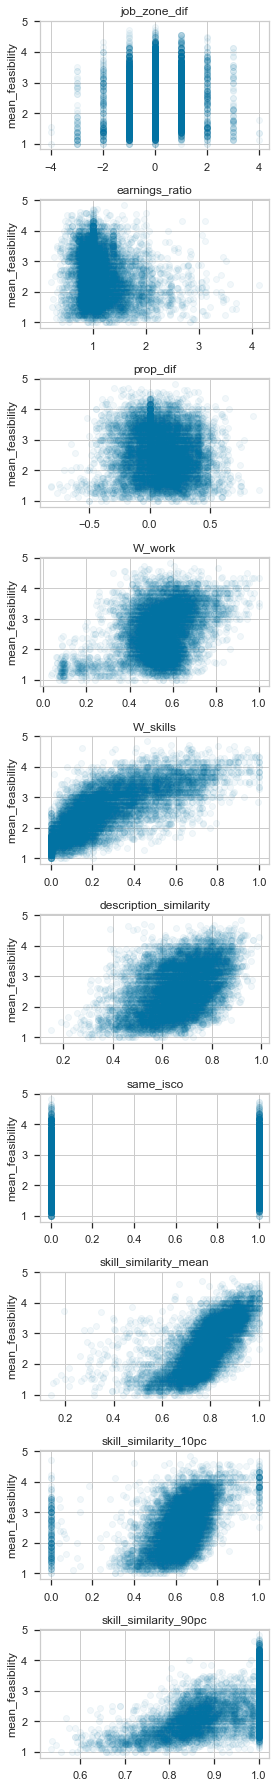

In [390]:
fig, axs = plt.subplots(nrows=len(feature_cols), figsize=(4, 2.5*len(feature_cols)))

for ax, col in zip(axs, feature_cols):
    ax.scatter(transitions_df[col], transitions_df[target_col], alpha=0.05)
    ax.set_title(col)
    ax.set_ylabel('mean_feasibility')
    
plt.tight_layout();

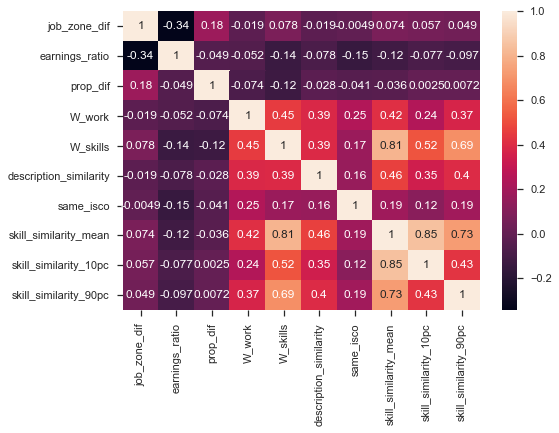

In [391]:
sns.heatmap(transitions_df[feature_cols].corr(), annot=True)

## 4. Model

Model to predict transition feasibility:

- Create a binary vector of skill pairs to represent each job and train a regression model to predict feasibility
- Create a model of averaged origin and destination skill embeddings and train a regression model to predict feasibility
- Combination of similarity measures that we already have

New features

- Specialisation of skills (overall and adjusted overlap)

### 4.1 Simple Model - Linear Regression on Similarity Scores

In [392]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from yellowbrick.regressor import ResidualsPlot

In [393]:
for col in feature_cols:
    transitions_df[col] = transitions_df[col].fillna(transitions_df[col].mean())

In [394]:
X_train, X_test, y_train, y_test = train_test_split(transitions_df[feature_cols], 
                                                    transitions_df[target_col], 
                                                    random_state=0, test_size=0.2, train_size=0.8)

### Linear Regression

In [395]:
polynomial_features = PolynomialFeatures(degree=2)
regression = LinearRegression()
pipeline = Pipeline([
#     ("polynomial_features", polynomial_features),
     ("regression", regression)])

In [418]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# The coefficients
print('Coefficients:')
[print(r, c) for r, c in zip(feature_cols, pipeline['regression'].coef_)]
# The mean squared error
print('\n Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients:
job_zone_dif 0.05141410200487661
earnings_ratio -0.09575145821218362
prop_dif -0.08110087918227249
W_work -0.17035342842442383
W_skills 1.4851243809231764
description_similarity 1.0618518688992367
same_isco -0.03596408124639954
skill_similarity_mean 2.166197978505107
skill_similarity_10pc -0.9275095351645162
skill_similarity_90pc 1.4976835052006234

 Mean squared error: 0.23
Coefficient of determination: 0.61


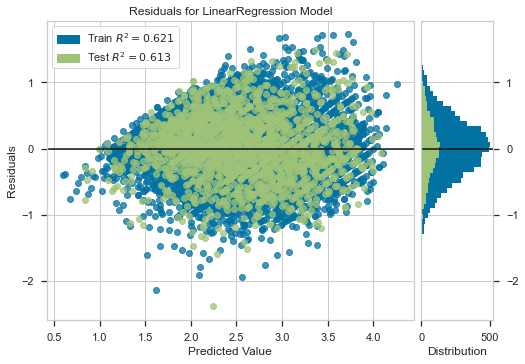

In [397]:
visualizer = ResidualsPlot(pipeline)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

### Support Vector Regression

In [398]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform, uniform
from sklearn.metrics import mean_squared_error, SCORERS

In [400]:
params = {
    'C': loguniform(1e-1, 1e3),
    'gamma': loguniform(1e-1, 1e2),
    'epsilon': uniform(0, 1)
         }

svr = SVR()
regressor = RandomizedSearchCV(
    svr, n_iter=500, param_distributions=params, 
    scoring='neg_mean_squared_error', n_jobs=-2, 
    random_state=0, verbose=3)

In [401]:
regressor.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 282 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-2)]: Done 506 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-2)]: Done 1146 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-2)]: Done 1562 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-2)]: Done 2042 tasks      | elapsed: 82.3min
[Parallel(n_jobs=-2)]: Done 2500 out of 2500 | elapsed: 98.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=500, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x145455da0>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x15d7a1828>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x145431710>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=3)

In [402]:
best = regressor.best_estimator_

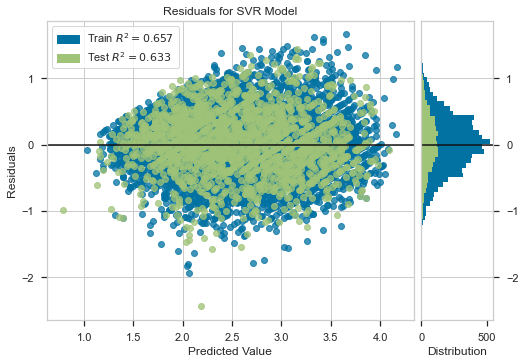

In [403]:
visualizer = ResidualsPlot(best)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

In [404]:
y_pred = best.predict(X_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.22
Coefficient of determination: 0.63


In [405]:
best.get_params()

{'C': 35.845670682223236,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.4299967804707131,
 'gamma': 0.12800532821280494,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Optimise SVR

In [196]:
params_opt = {
    'C': uniform(9, 13),
    'gamma': uniform(.15, .25),
    'epsilon': uniform(.12, .32)
         }

svr_opt = SVR()
regressor_opt = RandomizedSearchCV(
    svr_opt, n_iter=100, param_distributions=params_opt, 
    scoring='neg_mean_squared_error', n_jobs=-2, 
    random_state=0, verbose=3)

In [197]:
regressor_opt.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 282 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x139b08710>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x139b08080>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x139b08048>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=3)

In [198]:
best_opt = regressor_opt.best_estimator_

In [199]:
best_opt.get_params()

{'C': 21.06505681505268,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.34541260861553047,
 'gamma': 0.15795973238282696,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

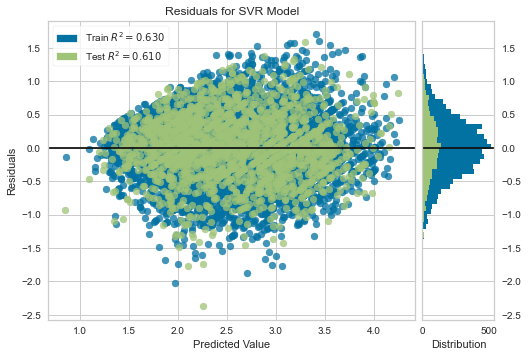

In [203]:
visualizer = ResidualsPlot(best_opt)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [202]:
y_pred = best_opt.predict(X_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.23
Coefficient of determination: 0.61


# Classification

Try the same problem but as a classification where feasible transitions are those with at least 1/3 ratings above 2.

In [327]:
batch_results['gt_2'] = batch_results['feasibility_1-5'] >= 3
is_feasible = batch_results.groupby('subject_ids')['gt_2'].mean() > 1/3
transitions_df['is_feasible'] = is_feasible

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



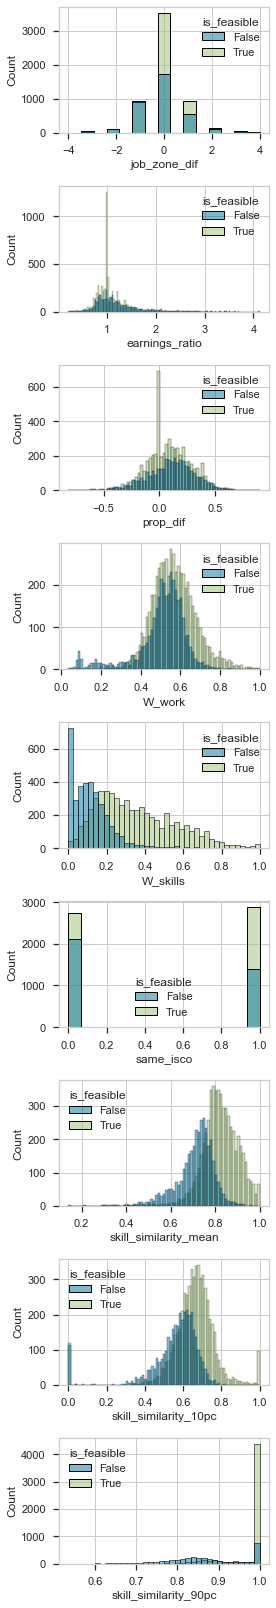

In [335]:
target_col = 'is_feasible'

fig, axs = plt.subplots(nrows=len(feature_cols), figsize=(4, 2.5*len(feature_cols)))

for ax, col in zip(axs, feature_cols):
    sns.histplot(data=transitions_df, x=col, hue=target_col, ax=ax, common_norm=True)
    
plt.tight_layout();

In [340]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [337]:
X_train, X_test, y_train, y_test = train_test_split(transitions_df[feature_cols], 
                                                    transitions_df[target_col], 
                                                    random_state=0, test_size=0.2, train_size=0.8)

In [338]:
knc = KNeighborsClassifier()

knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [339]:
preds = knc.predict(X_test)

In [341]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.72      0.70      0.71       731
        True       0.80      0.82      0.81      1092

    accuracy                           0.77      1823
   macro avg       0.76      0.76      0.76      1823
weighted avg       0.77      0.77      0.77      1823



# Other Thoughts

Do we need another measure of skills similarity - where skills are structurally or semantically similar in the web of skills?

- Calculate the proportion of actual low feasibility options that do make it through and the proportion of high feasibility that are cut out depending on different thresholds